In [1]:
import pandas as pd

dataToParse = "../data/reddit.csv"
data= pd.read_csv(dataToParse)
data.iloc[:10, :]

,title,score,subreddit,url,num_comments,body,date
0,UPVOTE so everyone sees we got SUPPORT,265029,wallstreetbets,https://i.redd.it/sgoqy8nyt2e61.png,11825,NaN,2021-01-29 00:40:34
1,GME YOLO update — Jan 28 2021,230844,wallstreetbets,https://i.redd.it/opzucppb15e61.png,23532,NaN,2021-01-29 08:06:23
2,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,204920,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,18318,LEAVE ROBINHOOD. They dont deserve to make mon...,2021-01-29 00:49:11
3,GME YOLO update — Jan 27 2021 ----------------...,185949,wallstreetbets,https://i.redd.it/a309gkm5yxd61.png,15495,NaN,2021-01-28 08:15:35
4,Can we all take a moment and appreciate the Mo...,184517,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,7105,NaN,2021-01-28 11:57:32
5,IT'S POWER TO THE TRADERS NOW,180878,wallstreetbets,https://v.redd.it/lu8aekujd6e61,5338,NaN,2021-01-29 12:35:58
6,Crazy mannnnnnn. We can't let this slide at all,166492,wallstreetbets,https://i.redd.it/8bels7zob4e61.jpg,2485,NaN,2021-01-29 05:42:01
7,"It runs very deep, my friends.",165358,wallstreetbets,https://i.redd.it/b8zy92sy85e61.jpg,2796,NaN,2021-01-29 08:47:55
8,AOC got our backs,164232,wallstreetbets,https://i.redd.it/3v5c5quc5yd61.png,5394,NaN,2021-01-28 08:55:22
9,I’m so proud of you all.,160021,wallstreetbets,https://i.redd.it/ykiux57d65e61.jpg,2536,NaN,2021-01-29 08:33:21


In [2]:
data_cleaned = data.dropna(subset=['body'])

<AxesSubplot:>

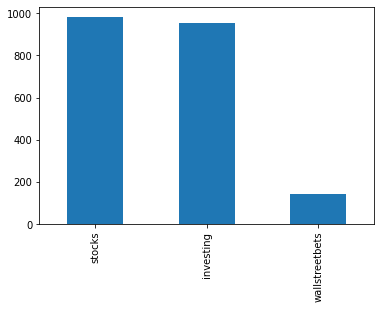

In [3]:
data_cleaned['subreddit'].value_counts().plot(kind='bar')

In [4]:
data_cleaned.reset_index(inplace = True, drop = True)
data_cleaned.index.name = "index_num"
data_cleaned.to_csv("../data/reddit_cleaned.csv")

In [5]:
posts_sentences = data_cleaned
posts_sentences['post_index'] = posts_sentences.index

C:\Users\user\AppData\Local\Temp/ipykernel_1780/3289262602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_sentences['post_index'] = posts_sentences.index


In [6]:
import re
import unidecode
from html import unescape
from quantulum3 import parser

def word_clean(words):
    '''
    remove non-latin words and perform simple clean ups to make the unit and number detection better
    :param words: a sentence
    :return:
    '''

    RE = re.compile(u'[⺀-⺙⺛-⻳⼀-⿕々〇〡-〩〸-〺〻㐀-䶵一-鿃豈-鶴侮-頻並-龎]', re.UNICODE)
    line = re.sub(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', u'', words)
    line = unidecode.unidecode(line)
    line = line.lower()
    line = line.encode("ascii", errors="ignore").decode()
    line = unescape(line)
    line = RE.sub('', line)
    line = re.sub(r"\s+", " ", line)
    line = re.sub(r"[;,#]+", "", line)
    line = re.sub(r"(\[\]|\(\)|\{\})", "", line)
    line = re.sub(r"\d/\d", "", line)
    line = re.sub(r"\'\d+", "", line)
    line = re.sub(r"\d+:\d+\spm", "", line)
    line = re.sub(r"\d+:\d+\sam", "", line)
    line = re.sub(r"third-world", "", line)
    line = re.sub(r"\'", "", line)
    line = re.sub(r"\"", "", line)
    line = re.sub(r"(_date)+", "_date", line)
    line = re.sub(r"fahrenheit20", "fahrenheit 20", line)
    dimensions = re.findall(r'\d+x\d+', line)
    for dim in dimensions:
        line = line.replace(dim, dim.replace('x', ' x '))

    attached_dollars = re.findall(r'[\w\d]+\$[\w\d]+', line)
    for dim in attached_dollars:
        line = line.replace(dim, dim.replace('$', ' $'))

    ps_dollars = re.findall(r'ps[\d]+', line)
    for dim in ps_dollars:
        line = line.replace(dim, dim.replace('ps', '$'))

    us_dollars = re.findall(r'\$us[\d]+', line)
    for dim in us_dollars:
        line = line.replace(dim, dim.replace('$us', '$'))

    dashes = re.findall(r'\d+\.*\d*\-[a-zA-Z]', line)
    for dim in dashes:
        line = line.replace(dim, dim.replace('-', ' '))

    m_for_million = re.findall(r'\$[\d]+m', line)
    for dim in m_for_million:
        line = line.replace(dim, dim.replace('m', ' million'))

    line = line.replace('-million', ' million')
    m = re.match(r'^\d+.\s*', line[:4])  # remove enumaration
    if m:
        line = line.replace(m.group(0), "")
    line = re.sub('\s+|\s+$|\s+(?=\s)', " ", line)  # remove additional white spaces

    degrees = re.findall(r'\d+degc', line)
    for dim in degrees:
        line = line.replace(dim, dim.replace('degc', ' celsius'))

    degrees2 = re.findall(r'\d+degf', line)
    for dim in degrees2:
        line = line.replace(dim, dim.replace('degf', ' degf'))

    degrees3 = re.findall(r'\d+degf', line)
    for dim in degrees3:
        line = line.replace(dim, dim.replace('deg', ' degree'))
    line = line.replace("degf", "fahrenheit")
    line = line.replace("degc", "celsius")

    bn_for_billion = re.findall(r'\$[\d]+bn', line)
    for dim in bn_for_billion:
        line = line.replace(dim, dim.replace('bn', ' billion'))

    tn_for_trillion = re.findall(r'\$[\d]+tn', line)
    for dim in tn_for_trillion:
        line = line.replace(dim, dim.replace('tn', ' trillion'))

    m_for_mm = re.findall(r'[\d]+\:[\d]+[pmam]+', line)
    for dim in m_for_mm:
        line = line.replace(dim, dim + "_date")

    pm = re.findall(r'[\d]+[\:]*[\d]*\sp.m.', line)
    for dim in pm:
        line = line.replace(dim.split(" ")[0], dim.split(" ")[0] + "_date")

    am = re.findall(r'[\d]+[\:]*[\d]*\sa.m.', line)
    for dim in am:
        line = line.replace(dim.split(" ")[0], dim.split(" ")[0] + "_date")

    line = line.replace("billion_date", "billion")
    line = line.replace("million_date", "million")
    line = line.replace("_date ppm", " ppm")
    line = line.replace("co2_date", "co2")
    line = line.replace("_date%", "%")

    return line

def hasNumbers(inputString):  # if the token contains numbers
    return any(char.isdigit() for char in inputString)

def apply_quantulum(sentence_text):
    '''
    Detect numbers in the sentence with their units
    :param sentence_text: text of a sentence
    :return:
    '''
    try:
        quants = parser.parse(sentence_text)
        quants_cleaned = [q for q in quants if hasNumbers(q.surface)]
    except:
        quants_cleaned = []

    return quants_cleaned

unit_set = {"square mile", "parts-per-billion", "terabyte", "dollar per barrel", "litre", "kilometre per hour",
            "solar mass", "kelvin", "ton of refrigeration", "japanese yen", "cubic gigaton", "kiloyear", "hour",
            "cubic metre", "metre", "square foot", "zettabyte", "micrometre", "gigawatt hour",
            "brazilian real", "pound per square inch", "gigahertz", "millimetre", "dollar per gallon", "kilowatt",
            "barrel", "cubic centimetre", "gauss", "terawatt", "joule", "picometre", "south korean won",
            "volt watt", "knot", "drop", "terawatt hour", "nanosecond", "nucleotide", "candela", "parts-per-million",
            "kilohertz", "centimetre", "quart", "bushel tonne", "kilometre", "per inch", "gigaton", "inch", "megapixel",
            "megawatt", "teravolt", "cubic tonne", "dollar", "horsepower", "electronvolt", "volt", "tonne", "megahertz",
            "euro", "centimetre per kiloyear", "square kilometre", "milliampere-hour", "second", "millisecond",
            "square metre", "mile", "kilogram", "turn", "degree angle", "pound-mass", "foot", "ampere", "bit",
            "hertz", "league", "calorie", "nanometre", "byte", "revolutions per minute", "nanoampere", "russian ruble",
            "carat", "astronomical unit", "gigabit per second", "gallon", "megayear", "degree fahrenheit",
            "degree Celsius", "gigapascal", "newton", "minute", "gigawatt", "watt", "megabit per second", "quintal",
            "foot per second", "gram cubic centimetre", "mile per hour", "indian rupee", "cent per gallon", "gross",
            "inverse second", "second of arc", "percentage", "decibel", "light-year", "bar", "lumen", "hectare", "gram",
            "cent", "microgram", "pixel", "acre", "kilowatt hour", "gigabyte", "chinese yuan",
            "percentage drop", "ounce", "yard", "cubic foot", "ampere-hour", "milliwatt", "millicoulomb", "radian",
            "canadian dollar", "australian dollar", "inning", "stone"}

def clean_units(quants):
    for quant in quants:

        quant.unit.name = quant.unit.name.replace(" per ampere-turn", "")
        quant.unit.name = quant.unit.name.replace(" ampere-turn", "")
        quant.unit.name = quant.unit.name.replace("ampere-turn ", "")
        quant.unit.name = quant.unit.name.replace(" ampere-turn ", "")

        quant.unit.name = quant.unit.name.replace("per cent", "percentage")
        quant.unit.name = re.sub(r'^percentage\s', "percentage", quant.unit.name)

        quant.unit.name = quant.unit.name.replace("dollar canadian dollar", "canadian dollar")
        quant.unit.name = quant.unit.name.replace("dollar astronomical unit", "australian dollar")
        quant.unit.name = quant.unit.name.replace("dollar hour astronomical unit year year", "australian dollar")

        quant.unit.name = re.sub(r'^dollar\s', "dollar", quant.unit.name)

        quant.unit.name = quant.unit.name.replace("inch newton inch gauss", "inning")
        quant.unit.name = quant.unit.name.replace("stere", "stone")
        quant.unit.name = quant.unit.name.replace("gallon year", "gallon")
        quant.unit.name = quant.unit.name.replace("kilometre hour", "kilometre per hour")
        quant.unit.name = quant.unit.name.replace("gram gram", "gram")
        quant.unit.name = quant.unit.name.replace("tonne tonne", "tonne")
        quant.unit.name = quant.unit.name.replace("mile per hour year", "mile per hour")
        quant.unit.name = quant.unit.name.replace("degree angle volt", "degree angle")
        quant.unit.name = quant.unit.name.replace("litre litre", "litre")
        quant.unit.name = quant.unit.name.replace("year atomic mass unit", "year")
        quant.unit.name = quant.unit.name.replace("kilowatt hour year", "kilowatt hour")

        if quant.unit.name not in unit_set:
            quants.remove(quant)

    return quants

In [7]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])  # pipeline for sentence splitting
nlp.add_pipe('sentencizer')

In [8]:
sentences_processed = []
paragraphs_processed = []
for i in range(posts_sentences.shape[0]):
    print(i)
    body = posts_sentences['body'][i]
    post_index = posts_sentences['post_index'][i]
    url = posts_sentences['url'][i]
    subreddit = posts_sentences['subreddit'][i]
    title = posts_sentences['title'][i]
    date = posts_sentences['date'][i]
    num_comments = posts_sentences['num_comments'][i]
    score = posts_sentences['score'][i]

    paragraphs = body.splitlines()
    paragraph_index = 0
    for paragraph in paragraphs:
        paragraph = word_clean(paragraph)
        sentences = nlp(paragraph)
        paragraph = paragraph.replace("_date", "")
        if paragraph != "" and paragraph.strip() and paragraph != "n/a":
            for sentence in sentences.sents:
                sentence = sentence.text
                if len(sentence) > 20 and not sentence.startswith("photo:") and not sentence.startswith("image:") and sentence != "n/a":
                    quants = [q for q in apply_quantulum(sentence) if q.unit.name != "dimensionless" and not hasNumbers(q.unit.name)]
                    quants = clean_units(quants)
                    units = [quant.unit.name for quant in quants]
                    values = [round(quant.value, 2) for quant in quants]
                    surfaces = [quant.surface for quant in quants]
                    sentence = sentence.replace("_date", "")
                    sentences_processed.append([post_index, url, subreddit, title, date, num_comments, score, sentence, units, values, surfaces, paragraph_index])
            paragraphs_processed.append([post_index, url, subreddit, title, date, num_comments, score, paragraph, paragraph_index])
            paragraph_index += 1


0


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.2 when using version 1.0.2. This might lead to bre

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [9]:
sentences_processed = pd.DataFrame(sentences_processed, columns=["post_index", "url", "subreddit", "title", "date", "num_comments", "score", "sentence", "units", "values", "surfaces", "paragraph_index"])
sentences_processed.index.name = "index_num"
sentences_processed = sentences_processed.dropna(subset=['sentence'])
sentences_processed.iloc[:100, :]

,post_index,url,subreddit,title,date,num_comments,score,sentence,units,values,surfaces,paragraph_index
index_num,,,,,,,,,,,,
0,0,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,2021-01-29 00:49:11,18318,204920,they dont deserve to make money off us after t...,[],[],[],0
1,0,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,2021-01-29 00:49:11,18318,204920,it might take a couple of days but send robinh...,[],[],[],0
2,1,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",2021-01-29 01:32:00,23210,157980,edit* not just canadians!!,[],[],[],0
3,1,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",2021-01-29 01:32:00,23210,157980,the whole world is coming to help now!!,[],[],[],0
4,1,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",2021-01-29 01:32:00,23210,157980,edit2* we are a global force to be reckoned wi...,[],[],[],1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"Can you say ""CLASS ACTION LAWSUIT"". Fuck you R...",2021-01-29 00:16:43,4139,86050,bought 15 shares @327.,[],[],[],3
96,5,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"Can you say ""CLASS ACTION LAWSUIT"". Fuck you R...",2021-01-29 00:16:43,4139,86050,waiting for another dip to yolo 12.7k into the...,[],[],[],3
97,5,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"Can you say ""CLASS ACTION LAWSUIT"". Fuck you R...",2021-01-29 00:16:43,4139,86050,i have 18 shares holding on rh with average co...,[dollar],[112.0],[$112],3


In [10]:
paragraphs_processed = pd.DataFrame(paragraphs_processed, columns=["post_index", "url", "subreddit", "title", "date", "num_comments", "score", "paragraph", "paragraph_index"])
paragraphs_processed.index.name = "index_num"
paragraphs_processed = paragraphs_processed.dropna(subset=['paragraph'])
paragraphs_processed.iloc[:10, :]

,post_index,url,subreddit,title,date,num_comments,score,paragraph,paragraph_index
index_num,,,,,,,,,
0,0,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,CLASS ACTION AGAINST ROBINHOOD. Allowing peopl...,2021-01-29 00:49:11,18318,204920,leave robinhood. they dont deserve to make mon...,0
1,1,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",2021-01-29 01:32:00,23210,157980,edit* not just canadians!! the whole world is ...,0
2,1,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"AMERICANS CAN'T BUY GME, BB?!?! HELP IS ON THE...",2021-01-29 01:32:00,23210,157980,edit2* we are a global force to be reckoned wi...,1
3,2,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"An Open Letter to Melvin Capital, CNBC, Boomer...",2021-01-28 16:06:14,7802,138569,**mods do not delete this is important to me ...,0
4,2,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"An Open Letter to Melvin Capital, CNBC, Boomer...",2021-01-28 16:06:14,7802,138569,​,1
5,2,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"An Open Letter to Melvin Capital, CNBC, Boomer...",2021-01-28 16:06:14,7802,138569,i was in my early teens during the crisis. i v...,2
6,2,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"An Open Letter to Melvin Capital, CNBC, Boomer...",2021-01-28 16:06:14,7802,138569,those close to me my friends and extended fami...,3
7,2,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"An Open Letter to Melvin Capital, CNBC, Boomer...",2021-01-28 16:06:14,7802,138569,to melvin capital: you stand for everything th...,4
8,2,https://www.reddit.com/r/wallstreetbets/commen...,wallstreetbets,"An Open Letter to Melvin Capital, CNBC, Boomer...",2021-01-28 16:06:14,7802,138569,to cnbc: you must realize your short term gain...,5


In [11]:
sentences_processed = sentences_processed.loc[:, ["post_index", "url", "subreddit", "title", "date", "num_comments", "score", "sentence", "units", "values", "surfaces", "paragraph_index"]]
sentences_processed.to_csv("../data/reddit_sentences_processed.csv")

paragraphs_processed = paragraphs_processed.loc[:, ["post_index", "url", "subreddit", "title", "date", "num_comments", "score", "paragraph", "paragraph_index"]]
paragraphs_processed.to_csv("../data/reddit_paragraphs_processed.csv")